In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import seaborn as sns

In [22]:
data=pd.read_csv("train.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


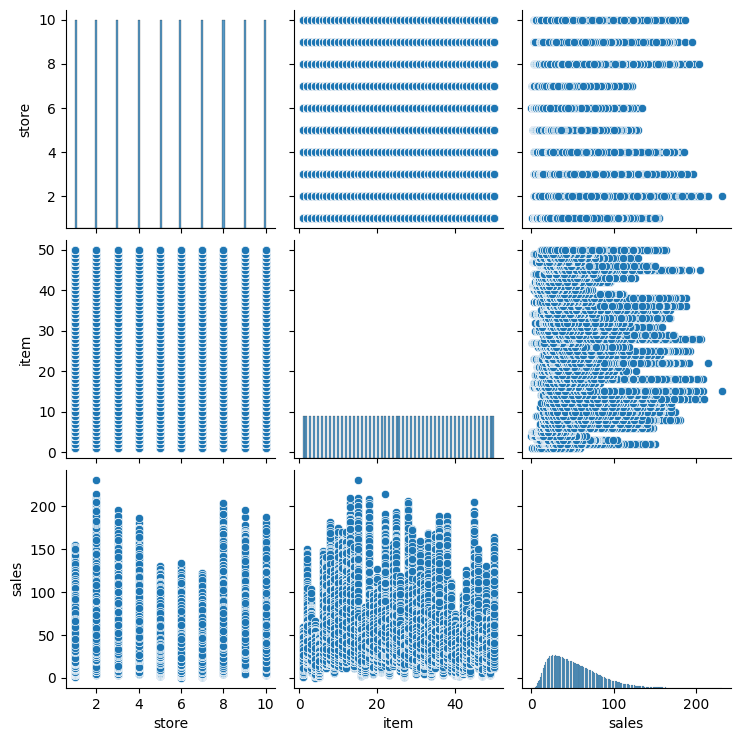

In [24]:
data1=data.drop(['date'],axis=1)
sns.pairplot(data1)

In [5]:
# check for null values
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

Dropping item and stores

In [6]:
data = data.drop(['store','item'], axis=1 )

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [8]:
data['date']=pd.to_datetime(data['date'])

In [13]:
data['date']=data['date'].dt.to_timestamp()


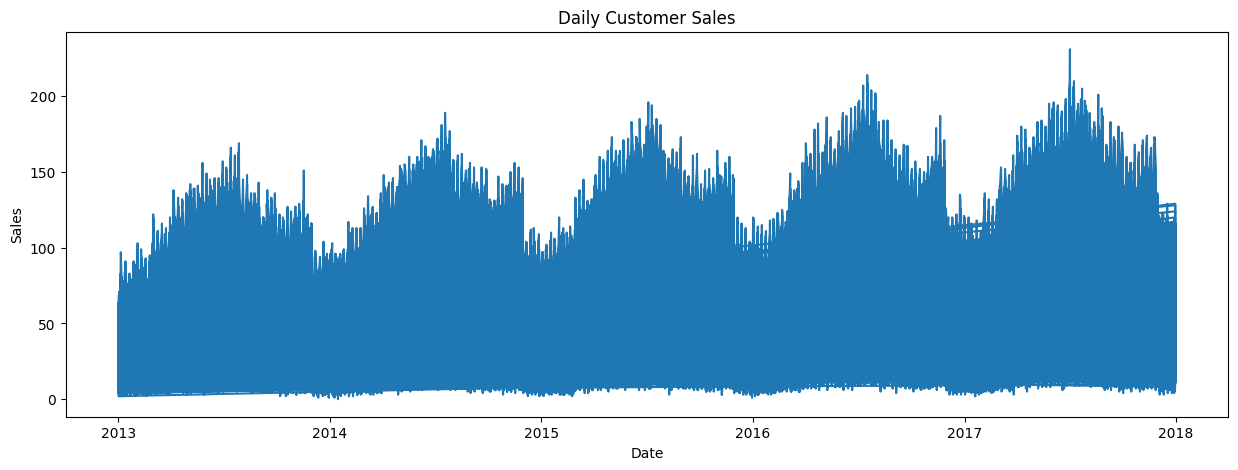

In [10]:
plt.figure(figsize=(15,5))
plt.plot(data['date'], data['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Daily Customer Sales")
plt.show()

In [11]:
data['date']=data['date'].dt.to_period("W")
week_sales=data.groupby('date').sum().reset_index()

In [12]:
week_sales.head(10)

,date,sales
0,2012-12-31/2013-01-06,91067
1,2013-01-07/2013-01-13,103902
2,2013-01-14/2013-01-20,102950
3,2013-01-21/2013-01-27,103298
4,2013-01-28/2013-02-03,109027
5,2013-02-04/2013-02-10,114566
6,2013-02-11/2013-02-17,115261
7,2013-02-18/2013-02-24,114766
8,2013-02-25/2013-03-03,125816
9,2013-03-04/2013-03-10,137705


In [14]:
week_sales['date']=week_sales['date'].dt.to_timestamp()

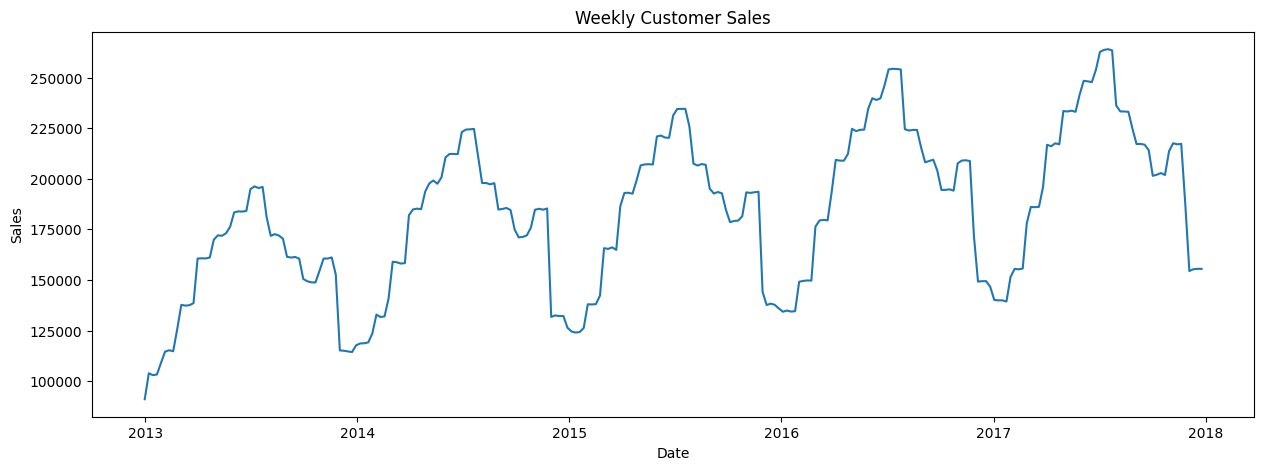

In [15]:
plt.figure(figsize=(15,5))
plt.plot(week_sales['date'], week_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Weekly Customer Sales")
plt.show()

In [16]:
week_sales['sales_diff']=week_sales['sales'].diff()
week_sales=week_sales.dropna()
week_sales.head(10)


,date,sales,sales_diff
1,2013-01-07,103902,12835.0
2,2013-01-14,102950,-952.0
3,2013-01-21,103298,348.0
4,2013-01-28,109027,5729.0
5,2013-02-04,114566,5539.0
6,2013-02-11,115261,695.0
7,2013-02-18,114766,-495.0
8,2013-02-25,125816,11050.0
9,2013-03-04,137705,11889.0
10,2013-03-11,137305,-400.0


In [17]:
supervised_data=week_sales.drop(['date','sales'], axis=1)

In [18]:
for i in range(1,53):
  col_name="week"+str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)  
supervised_data.head(10)  

,sales_diff,week1,week2,week3,week4,week5,week6,week7,week8,week9,...,week43,week44,week45,week46,week47,week48,week49,week50,week51,week52
0,911.0,3346.0,-319.0,-340.0,-183.0,-37454.0,-8453.0,533.0,17.0,6023.0,...,-400.0,11889.0,11050.0,-495.0,695.0,5539.0,5729.0,348.0,-952.0,12835.0
1,82.0,911.0,3346.0,-319.0,-340.0,-183.0,-37454.0,-8453.0,533.0,17.0,...,222.0,-400.0,11889.0,11050.0,-495.0,695.0,5539.0,5729.0,348.0,-952.0
2,450.0,82.0,911.0,3346.0,-319.0,-340.0,-183.0,-37454.0,-8453.0,533.0,...,986.0,222.0,-400.0,11889.0,11050.0,-495.0,695.0,5539.0,5729.0,348.0
3,4467.0,450.0,82.0,911.0,3346.0,-319.0,-340.0,-183.0,-37454.0,-8453.0,...,22050.0,986.0,222.0,-400.0,11889.0,11050.0,-495.0,695.0,5539.0,5729.0
4,9253.0,4467.0,450.0,82.0,911.0,3346.0,-319.0,-340.0,-183.0,-37454.0,...,120.0,22050.0,986.0,222.0,-400.0,11889.0,11050.0,-495.0,695.0,5539.0
5,-1177.0,9253.0,4467.0,450.0,82.0,911.0,3346.0,-319.0,-340.0,-183.0,...,-60.0,120.0,22050.0,986.0,222.0,-400.0,11889.0,11050.0,-495.0,695.0
6,296.0,-1177.0,9253.0,4467.0,450.0,82.0,911.0,3346.0,-319.0,-340.0,...,458.0,-60.0,120.0,22050.0,986.0,222.0,-400.0,11889.0,11050.0,-495.0
7,9010.0,296.0,-1177.0,9253.0,4467.0,450.0,82.0,911.0,3346.0,-319.0,...,8851.0,458.0,-60.0,120.0,22050.0,986.0,222.0,-400.0,11889.0,11050.0
8,17992.0,9010.0,296.0,-1177.0,9253.0,4467.0,450.0,82.0,911.0,3346.0,...,2090.0,8851.0,458.0,-60.0,120.0,22050.0,986.0,222.0,-400.0,11889.0
9,-253.0,17992.0,9010.0,296.0,-1177.0,9253.0,4467.0,450.0,82.0,911.0,...,-197.0,2090.0,8851.0,458.0,-60.0,120.0,22050.0,986.0,222.0,-400.0


Split data for previous and coming weeks

In [19]:
prev_data=supervised_data[:-52]
com_data=supervised_data[-52:]
print(prev_data.shape)
print(com_data.shape)

(156, 53)
(52, 53)


In [20]:
scaler= MinMaxScaler(feature_range=(-1,1))
scaler.fit(prev_data)
prev_data=scaler.transform(prev_data)
com_data=scaler.transform(com_data)

In [ ]:
X_prev, y_prev= prev_data[:,1:], prev_data[:,0:1]
X_com, y_com=com_data[:,1:],prev_data[:,0:1]
y_prev=y_prev.ravel()
y_com=y_com.ravel()


Prediction Model

In [ ]:
sales_dates=week_sales['date'][-52:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)


In [1]:
act_sales=week_sales['sales'][-53:].to_list()
print(act_sales)

NameError: ignored

Linear Regresson Model and Prediction

In [ ]:
lr_model=LinearRegression()
lr_model.fit(X_prev,y_prev)
lr_pre=lr_model.predict(X_com)


In [ ]:
lr_pre=lr_pre.reshape(-1,1)
lr_pre_com_set=np.concatenate([lr_pre,X_com],axis=1)
lr_pre_com_set=scaler.inverse_transform(lr_pre_com_set)

In [ ]:
result=[]
for j in range(0,len(lr_pre_com_set)):
  result.append(lr_pre_com_set[j][0]+act_sales[j])
lr_pre_series=pd.Series(result,name="Linear Regression")
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True) 

In [ ]:
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Regression'], week_sales['sales'][-52:]))
lr_mae=mean_squared_error(predict_df['Linear Regression'], week_sales['sales'][-52:])
lr_r2=r2_score(predict_df['Linear Regression'], week_sales['sales'][-52:])
print("Linear Regression in MSE ",lr_mse)
print("Linear Regression in MAE ",lr_mae)
print("Linear Regression in R2 ",lr_r2)

Linear Regression in MSE  269.0744175266429
Linear Regression in MAE  72401.04216730215
Linear Regression in R2  0.9756569540029858


Predicted vs Actual sales

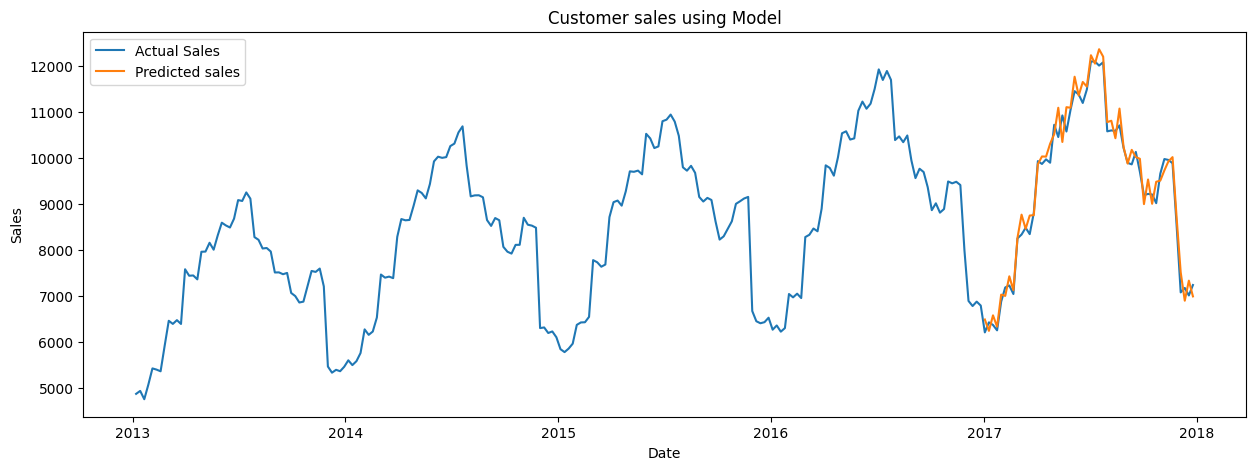

In [ ]:
plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(week_sales['date'],week_sales['sales'])
#predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Regression'])
plt.title("Customer sales using Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales','Predicted sales'])
plt.show()


StreamLit Application


In [ ]:
!pip install -q streamlit

In [ ]:
%%writefile app.py
import streamlit as st

st.title.("ML MODEL")
st.write("Hello")

Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.512s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
# !streamlit run app.py & npx localtunnel --port 8501